# Forecasting of bike rentals, based on time series including different weather parameters

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import zipfile

In [ ]:
!cp "/content/drive/My Drive/Datasets/bike-sharing-dataset.zip" .

In [ ]:
with zipfile.ZipFile("./bike-sharing-dataset.zip") as z:
  #z.printdir()
  z.extractall()

In [ ]:
!head -n 10 hour-fixed.csv

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1
6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.8,0,2,0,2
8,2011-01-01,1,0,1,7,0,6,0,1,0.2,0.2576,0.86,0,1,2,3
9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0,1,7,8


In [ ]:
"2011-01-01"[8:10]

'01'

In [ ]:
# conversion on first row - it can't parse it into a number because it is a date "2011-01-01"
# transform the date [8-10] into a date
bikes_np = np.loadtxt("hour-fixed.csv", dtype=np.float32, delimiter=",", skiprows=1,
                      converters={1: lambda x: float(x[8:10])})

In [ ]:
bikes = torch.from_numpy(bikes_np)

In [ ]:
features = ['instant', 'day', 'season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersituation', 'temperature', 'perceivedtemperature', 'humidity', 'windspeed', 'casual', 'registerdusers', 'rentalcounts']

In [ ]:
# 17,520 hours, 17 columns
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (17, 1))

In [ ]:
torch.unique(bikes[:,9])

tensor([1., 2., 3., 4.])

In [ ]:
weather_onehot = torch.zeros(bikes.shape[0], len(torch.unique(bikes[:,9])))
weather_onehot.shape

torch.Size([17520, 4])

In [ ]:
# -1 because we have set of values {1, 2, 3, 4}
weather_onehot.scatter_(dim=1, index=bikes[:,9].long().unsqueeze(1) - 1, value=1.0)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [ ]:
bikes.shape, torch.cat((bikes, weather_onehot), 1).shape

(torch.Size([17520, 17]), torch.Size([17520, 21]))

In [ ]:
# remove the weather situation column
bikes2 = torch.cat((bikes[:,:9], bikes[:,10:]), 1)

In [ ]:
bikes2[0,:], bikes2.shape

(tensor([ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,
          0.0000,  0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000, 16.0000]),
 torch.Size([17520, 16]))

In [ ]:
# add the one-hot weather situation
bikes3 = torch.cat((bikes2, weather_onehot), 1)

In [ ]:
# one-hot at the end
bikes3[0,:], bikes3.shape

(tensor([ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,
          0.0000,  0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000, 16.0000,
          1.0000,  0.0000,  0.0000,  0.0000]),
 torch.Size([17520, 20]))

In [ ]:
# temperatures and the like seem to be already normalized
#bikes3[:,10] = torch.nn.functional.normalize(bikes[:,10], dim=0)
#bikes3[:,11] = torch.nn.functional.normalize(bikes[:,11], dim=0)

In [ ]:
# statistics of rental counts
bikes[:,16].min(), bikes[:,16].max(), bikes[:,16].mean(), bikes[:,16].median()

(tensor(0.), tensor(977.), tensor(187.9383), tensor(140.))

In [ ]:
# first column to remove: perform this earlier along with weather situation removal [!]
bikes3[:32,0], bikes3[:32,1]

(tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
         29., 29., 30., 31.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.]))

In [ ]:
bikes3[0,:]

tensor([ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,
         0.0000,  0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000, 16.0000,
         1.0000,  0.0000,  0.0000,  0.0000])

In [ ]:
# what's this ?
# look at registered and rental counts
# rental counts must be removed earlier as well [!]
torch.cat((bikes3[0,:15], bikes3[0,16:]))

tensor([ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,
         0.0000,  0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000,  1.0000,
         0.0000,  0.0000,  0.0000])

In [ ]:
bikes3.shape

torch.Size([17520, 20])

In [ ]:
# drop index and target columns
# following the concatenations, the target column is followed by the weather-one-hot
bikes4 = torch.cat((bikes3[:,1:15], bikes3[:,16:]), 1)
bikes4.shape

torch.Size([17520, 18])

In [ ]:
# 13 and 32 correspond to the registered counts
bikes4[:2,:]

tensor([[ 1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,  0.0000,
          0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000,  1.0000,  0.0000,
          0.0000,  0.0000],
        [ 1.0000,  1.0000,  0.0000,  1.0000,  1.0000,  0.0000,  6.0000,  0.0000,
          0.2200,  0.2727,  0.8000,  0.0000,  8.0000, 32.0000,  1.0000,  0.0000,
          0.0000,  0.0000]])

In [ ]:
# groups by 24 to have daily time series to feed torch
#y = bikes3[:,15].view(-1, 24).long()
y = bikes3[:,15].view(-1, 24)
y.shape, y.stride()

(torch.Size([730, 24]), (480, 20))

In [ ]:
X = bikes4.view(-1, 24, bikes4.shape[1])
X.shape

torch.Size([730, 24, 18])

In [ ]:
X = X.transpose(1, 2)

In [ ]:
X.shape, X.stride()

(torch.Size([730, 18, 24]), (432, 1, 18))

In [ ]:
# this means n samples = 730, corresponds to 730 days

In [ ]:
730 * 0.8

584.0

In [ ]:
X_train, X_test = X[:584], X[584:]
y_train, y_test = y[:584], y[584:]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([584, 18, 24]),
 torch.Size([146, 18, 24]),
 torch.Size([584, 24]),
 torch.Size([146, 24]))

In [ ]:
X_train.reshape(584,-1).shape

torch.Size([584, 432])

In [ ]:
X_train2 = X_train.reshape(584,-1)
y_train2 = y_train.reshape(584,-1)
X_test2 = X_test.reshape(146,-1)
y_test2 = y_test.reshape(146,-1)

In [ ]:
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

(torch.Size([584, 432]),
 torch.Size([146, 432]),
 torch.Size([584, 24]),
 torch.Size([146, 24]))

In [ ]:
X_train2.dtype, X_test2.dtype, y_train2.dtype, y_test2.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

Two neural networks: one that converges, one that does not

In [ ]:
class BikesRentalForecastBasicNetworkConverge(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.flatten = torch.nn.Flatten()
      self.linear_relu_stack = torch.nn.Sequential(
          torch.nn.Linear(432, 64, dtype=torch.float32),
          torch.nn.ReLU(),
          torch.nn.Linear(64, 24, dtype=torch.float32),
        )

    def forward(self, x):
      logits = self.linear_relu_stack(x)
      return logits

In [ ]:
class BikesRentalForecastBasicNetworkDiverge(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.flatten = torch.nn.Flatten()
      self.linear_relu_stack = torch.nn.Sequential(
          torch.nn.Linear(432, 128, dtype=torch.float32),
          torch.nn.ReLU(),
          torch.nn.Linear(128, 64, dtype=torch.float32),
          torch.nn.ReLU(),
          torch.nn.Linear(64, 24, dtype=torch.float32),
        )

    def forward(self, x):
      logits = self.linear_relu_stack(x)
      return logits

In [ ]:
model = BikesRentalForecastBasicNetworkConverge()
#model = BikesRentalForecastBasicNetworkDiverge()
print(model)

BikesRentalForecastBasicNetworkConverge(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=432, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24, bias=True)
  )
)


In [ ]:
X_train2[0].shape

torch.Size([432])

In [ ]:
# outputs 24 numbers, as requested by the configured neural network
_ = model(X_train2[0]);
_, _.shape

(tensor([-1.4275, -0.0107, -0.6042,  0.5744, -0.7822,  0.2422,  0.8052,  0.8522,
         -0.9938,  0.6198, -0.8659, -0.0663, -0.9315,  0.0805, -0.5541,  1.5524,
          0.1771,  1.9539, -0.2971,  0.6933,  1.0109, -0.1232, -0.1701, -1.0988],
        grad_fn=<ViewBackward0>),
 torch.Size([24]))

In [ ]:
# time series contain 24 numbers as well, seems to match
y_train2[0].shape

torch.Size([24])

In [ ]:
# not appropriate here, we are doing linear regression, not logistic regression
#loss_func = F.cross_entropy

In [ ]:
loss_func = torch.nn.MSELoss()

In [ ]:
# adapted for time series and linear regression
# that is, it returns True if error within a given bound
# this is not used to train the model
def accuracy(out, yb, maxErr=3, verbose=False):
  if verbose:
    print(out.shape)
    print(yb.shape)
  # mean over the 24 days
  diff = (abs(out - yb) < maxErr).float().mean(axis=1)
  if verbose:
    print(diff.shape)
  # mean per time series, and then over all samples
  #return diff.astype(float).mean(axis=1).mean()
  return diff.mean()

In [ ]:
loss_func(model(X_train2[0]), y_train2[0])

tensor(2898.7146, grad_fn=<MseLossBackward0>)

In [ ]:
loss_func(model(X_train2), y_train2)

tensor(59233.4023, grad_fn=<MseLossBackward0>)

In [ ]:
accuracy(model(X_train2), y_train2)

tensor(0.0114)

In [ ]:
_ = model(X_train2[0]);
accuracy(_.unsqueeze(1), y_train2[0].unsqueeze(1))

tensor(0.1250)

In [ ]:
#def log_softmax(x):
#  return x - x.exp().sum(-1).log().unsqueeze(-1)

#def model(xb):
#  return log_softmax(xb @ weights + bias)

#def nll(input, target):
#  return -input[range(target.shape[0]), target].mean()

#loss_func = nll

#def accuracy(out, yb):
#  preds = torch.argmax(out, dim=1)
#  return (preds == yb).float().mean()

In [ ]:
loss_func(model(X_train2), y_train2)

tensor(57646.1172, grad_fn=<MseLossBackward0>)

In [ ]:
model(X_train2).shape, y_train2.shape

(torch.Size([584, 24]), torch.Size([584, 24]))

In [ ]:
model(X_train2)[:10].shape

torch.Size([10, 24])

In [ ]:
accuracy(model(X_train2), y_train2)

tensor(0.0343)

In [ ]:
print(
    loss_func(model(X_train2), y_train2).item(), accuracy(model(X_train2), y_train2).item(),
    "\n",
    loss_func(model(X_test2), y_test2).item(), accuracy(model(X_test2), y_test2).item()
    )

58478.953125 0.03667237609624863 
 111178.375 0.01912100613117218


In [ ]:
model(X_train2).shape

torch.Size([584, 24])

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
trainingLosses = []
validationLosses = []

In [ ]:
# beginner_source\basics\quickstart_tutorial.py
# without sending objects to gpu
def train(X, y, model, loss_fn, optimizer):
  size = len(X)
  model.train()

  # batches of 1 here
  for batch, (_X, _y) in enumerate(zip(X, y)):
    pred_train = model(_X)
    loss_train = loss_fn(pred_train, _y)

    loss_train.backward()
    optimizer.step()
    optimizer.zero_grad()

    pred_test = model(X_test2)
    loss_test = loss_fn(pred_test, y_test2)

    trainingLosses.append(loss_train.detach().numpy())
    validationLosses.append(loss_test.detach().numpy())

    if batch % 100 == 0:
      #loss, current = loss.item(), (batch + 1) * len(_X)
      loss_train, current = loss_train.item(), (batch + 1)
      print(f"loss: {loss_train:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# we obtain a loss at the start, and then we lose it to nan right away
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(X_train2, y_train2, model, loss_func, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2851.117188  [    1/  584]
loss: 33569.386719  [  101/  584]
loss: 53357.339844  [  201/  584]
loss: 39107.308594  [  301/  584]
loss: 24440.396484  [  401/  584]
loss: 84004.679688  [  501/  584]
Epoch 2
-------------------------------
loss: 2192.225586  [    1/  584]
loss: 30480.021484  [  101/  584]
loss: 49075.500000  [  201/  584]
loss: 35391.574219  [  301/  584]
loss: 21918.203125  [  401/  584]
loss: 78720.492188  [  501/  584]
Epoch 3
-------------------------------
loss: 1631.231079  [    1/  584]
loss: 27321.640625  [  101/  584]
loss: 45173.535156  [  201/  584]
loss: 32031.750000  [  301/  584]
loss: 19692.253906  [  401/  584]
loss: 73860.835938  [  501/  584]
Epoch 4
-------------------------------
loss: 1267.991577  [    1/  584]
loss: 24481.572266  [  101/  584]
loss: 41622.421875  [  201/  584]
loss: 28994.291016  [  301/  584]
loss: 17732.115234  [  401/  584]
loss: 69389.445312  [  501/  584]
Epoch 5
--------------------

In [ ]:
# previous run
print(
    loss_func(model(X_train2), y_train2).item(), accuracy(model(X_train2), y_train2).item(),
    "\n",
    loss_func(model(X_test2), y_test2).item(), accuracy(model(X_test2), y_test2).item()
    )

41224.7109375 0.08725742250680923 
 85286.8515625 0.04708904027938843


# Plotting the evolution of losses as the learning process goes

In [ ]:
import matplotlib.pyplot as plt

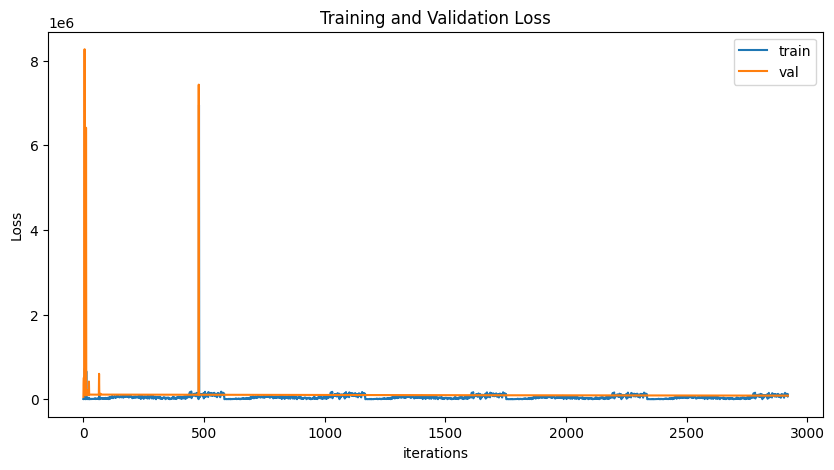

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(trainingLosses,label="train")
plt.plot(validationLosses,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# accidental typo here, but somehow seems to work better
trainingLosses2 = [ x if x < 1e3 else 1e2 for x in trainingLosses ]
validationLosses2 = [ x if x < 1e3 else 1e3 for x in validationLosses ]

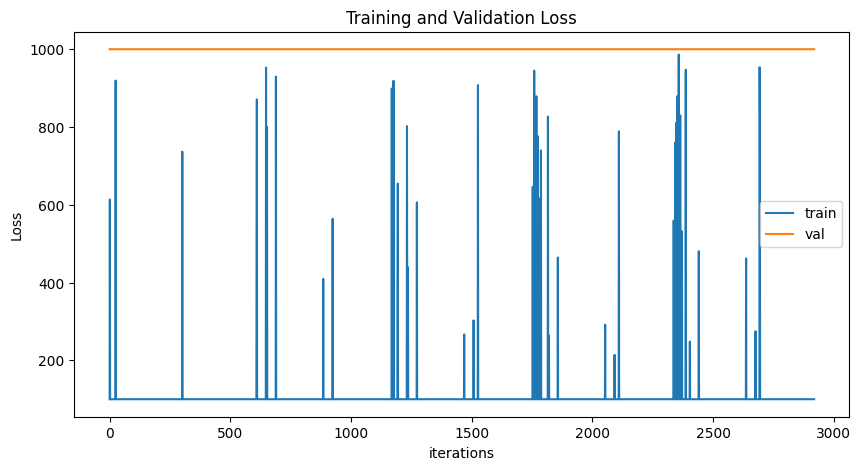

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(trainingLosses2,label="train")
plt.plot(validationLosses2,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Identifying the most critical weights in the process of forecasting

In [ ]:
model.linear_relu_stack

Sequential(
  (0): Linear(in_features=432, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=24, bias=True)
)

In [ ]:
# weights are a matrix that gets multiplied by vectors, aka samples
weights = model.linear_relu_stack[0].weight.detach().numpy()
weights.shape

(64, 432)

In [ ]:
I = [ (i, j) for i,j in zip(range(weights.shape[0]), range(weights.shape[1])) if abs(weights[i,j]) > 1 ]
I

[(5, 5), (14, 14), (18, 18), (42, 42)]

In [ ]:
[ weights[I[i][0], I[i][1]] for i in range(len(I))]

[-1.1870724, -4.3302116, -89.337105, -9.184773]

In [ ]:
bias = model.linear_relu_stack[0].bias.detach().numpy()
bias.shape

(64,)

In [ ]:
J = [ j for j in range(bias.shape[0]) if abs(bias[j]) > 1 ]
J

[18, 42, 58]

In [ ]:
[ bias[J[j]] for j in range(len(J))]

[-12.7514105, -2.2481642, -132.57063]